# CENG403 - Spring 2024 - THE3

# Task 2: CNN with PyTorch
In this task, you will implement a convolutional neural network (CNN) with PyTorch.


## 2.1 Import the Modules

Let us start with importing some libraries that we will use throughout the task.

In [9]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # NumPy, for working with arrays/tensors
import time                     # For measuring time
import random                   # Python's random library


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

!pip install torchinfo
from torchinfo import summary



## 2.2 Enable GPU

First, under "Edit -> Notebook Settings -> Hardware accelerator", select a GPU. With the following, we will inform PyTorch that we want to use the GPU.

In [10]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


## 2.3 The Dataset

We will use torchvision.datasets to download the CIFAR10 dataset.

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 2.3.1 Visualize Samples

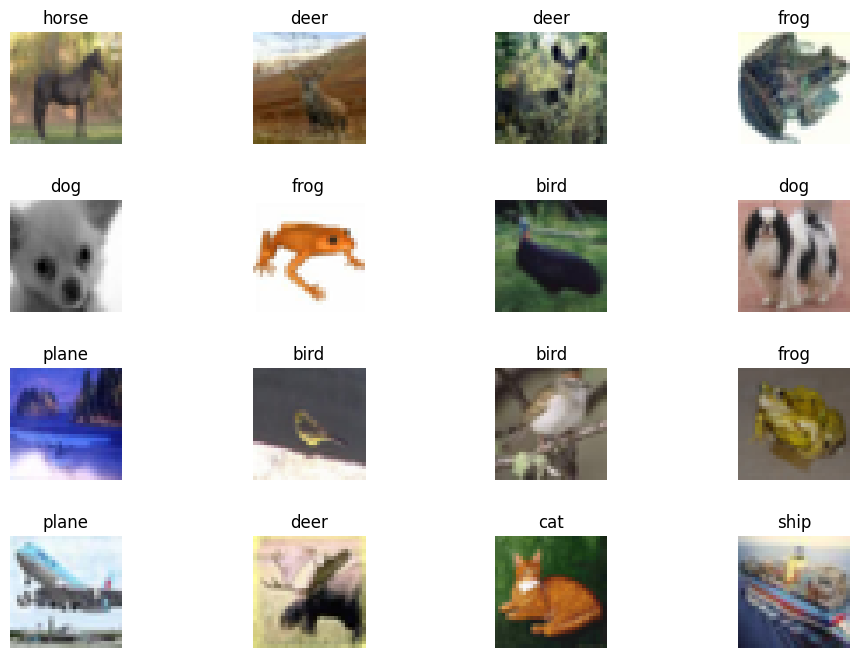

In [12]:
dataiter = iter(trainloader)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
S = 4

for i in range(S):
  for j in range(S):
    images, labels = next(dataiter)
    X = np.transpose(images[0].numpy()/2+0.5, (1, 2, 0))
    y = labels[0]

    plt.subplot(S, S, i*S+j+1)
    plt.imshow(X)
    plt.axis('off')
    plt.title(classes[y])
    plt.subplots_adjust(hspace = 0.5)

plt.show()

## 2.4 Define and Train a Small CNN Model

Now, all the pieces are ready and we can define a model.

### 2.4.1 Model Definition

Create a three-layer CNN with the following layers:

| Layer Name | Input HxW | Filter size | Stride | Pad | # of in channels | Out HxW | # of out channels |
| ----| -----| ----| ---| ---| ----| -----|---------- |
| Conv1   | 32x32 | ? | ? | ? | 3  | 28x28 | 16 |
| Conv2   | 28x28 | ? | ? | ? | 16 | 26x26 | 32 |
| Maxpool | 26x26 | 4 | 2 | 0 | 32 | 12x12 | 32 |
| Conv3   | 12x12 | ? | ? | ? | 32 | 10x10 | 32 |

and the fully-connected layers:

| Layer Name | Input Size | Output size |
| ----| -----| ----|
| FC1 | 3200 | 1500 |
| FC2 | 1500 | 10 |

You should choose suitable values for variables marked with `?' in the table and make sure that receptive fields can be properly placed in all layers.

While creating your model, pay attention to the following aspects:
* Each Conv layer and FC layer will be followed by ReLU, except for the last one.
* You should keep all other parameters (dilation, bias, group-mode, ..) as their default values in Pytorch.

You will need to read the following pages from Pytorch regarding the layers that you will use:
* [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=maxpool#torch.nn.MaxPool2d)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        torch.manual_seed(403)
        random.seed(403)
        np.random.seed(403)
        self.conv1 = None
        self.conv2 = None
        self.conv3 = None
        self.maxpool = None
        self.fc1 = None
        self.fc2 = None
        ###########################################################
        # @TODO: Create the convolutional and FC layers as        #
        #  described above.                                       #
        ###########################################################
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=2, padding=0)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(3200, 1500)
        self.fc2 = nn.Linear(1500, 10)
        ###########################################################
        #                         END OF YOUR CODE                #
        ###########################################################

    def forward(self, x):
      ###########################################################
      # @TODO: Feedforward x through the layers. Note that x    #
      # needs to be reshaped to (batchsize, 3200) before        #
      # the FC layers.                                          #
      ###########################################################
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))

      x = self.maxpool(x)

      x = F.relu(self.conv3(x))

      x = x.view(x.size(0), -1)

      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      ###########################################################
      #                         END OF YOUR CODE                #
      ###########################################################
      return x

### 2.4.2 Trainer for the Model

Let us define our training function, which will use the cuda device for training the model.

In [14]:
def train(model, criterion, optimizer, epochs, dataloader, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = []
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):

      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())

    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history

### 2.4.3 Create and visualize the model

In [15]:
model = SmallCNN()

summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
SmallCNN                                 [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 28, 28]         1,216
├─Conv2d: 1-2                            [128, 32, 26, 26]         4,640
├─MaxPool2d: 1-3                         [128, 32, 12, 12]         --
├─Conv2d: 1-4                            [128, 32, 10, 10]         9,248
├─Linear: 1-5                            [128, 1500]               4,801,500
├─Linear: 1-6                            [128, 10]                 15,010
Total params: 4,831,614
Trainable params: 4,831,614
Non-trainable params: 0
Total mult-adds (G): 1.26
Input size (MB): 1.57
Forward/backward pass size (MB): 39.82
Params size (MB): 19.33
Estimated Total Size (MB): 60.72

### 2.4.4 Train the Small Model

We will create an instance of our model and "define" which loss function we want to use. We will also state our choice for the optimizer here.

For more information, check the PyTorch docs: [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and [SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)
epochs = 10
loss_history = train(model, criterion, optimizer, epochs, trainloader)

Epoch 0 / 10: avg. loss of last 5 iterations 2.229353094100952
Epoch 1 / 10: avg. loss of last 5 iterations 1.936537504196167
Epoch 2 / 10: avg. loss of last 5 iterations 1.6451267004013062
Epoch 3 / 10: avg. loss of last 5 iterations 1.5956843137741088
Epoch 4 / 10: avg. loss of last 5 iterations 1.5260608434677123
Epoch 5 / 10: avg. loss of last 5 iterations 1.482478666305542
Epoch 6 / 10: avg. loss of last 5 iterations 1.397674059867859
Epoch 7 / 10: avg. loss of last 5 iterations 1.331014633178711
Epoch 8 / 10: avg. loss of last 5 iterations 1.2443934202194213
Epoch 9 / 10: avg. loss of last 5 iterations 1.2435826301574706


### 2.4.5 The Loss Curve

Let us visualize the loss curve.

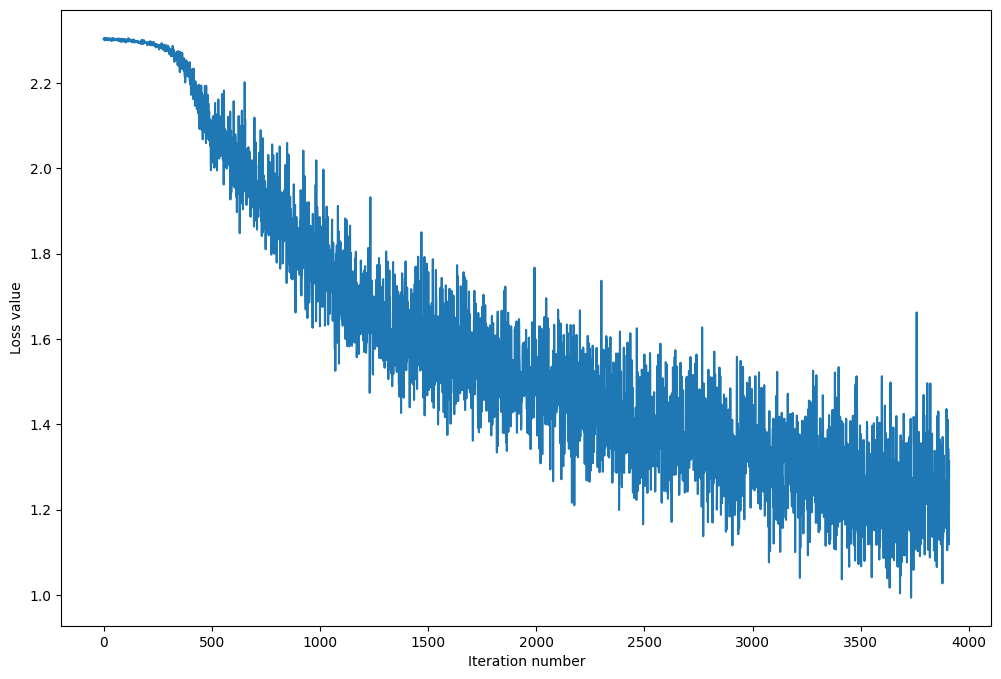

In [17]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 2.4.6 Quantitative Analysis

We can analyze the accuracy of the predictions as follows. You should see around 54\% accuracies. We can finetune the hyperparameters to obtain better results. But we will skip that and go for a bigger model.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [18]:
correct = 0
total = 0
model = model.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


## 2.5 Your CNN

Now, create your own CNN. It should have at least 5 convolutional layers. Other than that, there is no restriction on what you can use in your CNN or how you can structure it.


### 2.5.1 Model Definition

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class YourCNN(nn.Module):
    def __init__(self):
        super(YourCNN, self).__init__()
        torch.manual_seed(403)
        random.seed(403)
        np.random.seed(403)
        ###########################################################
        # @TODO: Create your layers here.                         #
        ###########################################################
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 32 * 32, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)
        ###########################################################
        #                         END OF YOUR CODE                #
        ###########################################################

    def forward(self, x):
      ###########################################################
      # @TODO: Feedforward x through the layers.                #
      ###########################################################
      x = F.relu(self.bn1(self.conv1(x)))
      x = F.relu(self.bn2(self.conv2(x)))
      x = F.relu(self.bn3(self.conv3(x)))
      x = F.relu(self.bn4(self.conv4(x)))
      x = F.relu(self.bn5(self.conv5(x)))
      x = x.view(x.size(0), -1)
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = self.fc2(x)
      ###########################################################
      #                         END OF YOUR CODE                #
      ###########################################################
      return x

### 2.5.2 Create and visuale your model

In [20]:
model = YourCNN()

summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
YourCNN                                  [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 32, 32]         448
├─BatchNorm2d: 1-2                       [128, 16, 32, 32]         32
├─Conv2d: 1-3                            [128, 32, 32, 32]         4,640
├─BatchNorm2d: 1-4                       [128, 32, 32, 32]         64
├─Conv2d: 1-5                            [128, 64, 32, 32]         18,496
├─BatchNorm2d: 1-6                       [128, 64, 32, 32]         128
├─Conv2d: 1-7                            [128, 128, 32, 32]        73,856
├─BatchNorm2d: 1-8                       [128, 128, 32, 32]        256
├─Conv2d: 1-9                            [128, 256, 32, 32]        295,168
├─BatchNorm2d: 1-10                      [128, 256, 32, 32]        512
├─Linear: 1-11                           [128, 512]                134,218,240
├─Dropout: 1-12                          [128, 512]     

### 2.5.3 Train the Model

In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)
epochs = 10
loss_history = train(model, criterion, optimizer, epochs, trainloader)

Epoch 0 / 10: avg. loss of last 5 iterations 1.2587950229644775
Epoch 1 / 10: avg. loss of last 5 iterations 1.024019718170166
Epoch 2 / 10: avg. loss of last 5 iterations 0.8643498420715332
Epoch 3 / 10: avg. loss of last 5 iterations 0.8322264075279235
Epoch 4 / 10: avg. loss of last 5 iterations 0.6486036777496338
Epoch 5 / 10: avg. loss of last 5 iterations 0.5458938777446747
Epoch 6 / 10: avg. loss of last 5 iterations 0.4753465116024017
Epoch 7 / 10: avg. loss of last 5 iterations 0.3404959738254547
Epoch 8 / 10: avg. loss of last 5 iterations 0.24988762736320497
Epoch 9 / 10: avg. loss of last 5 iterations 0.22290826439857483


### 2.5.4 Loss Curve

Let us visualize the loss curve.

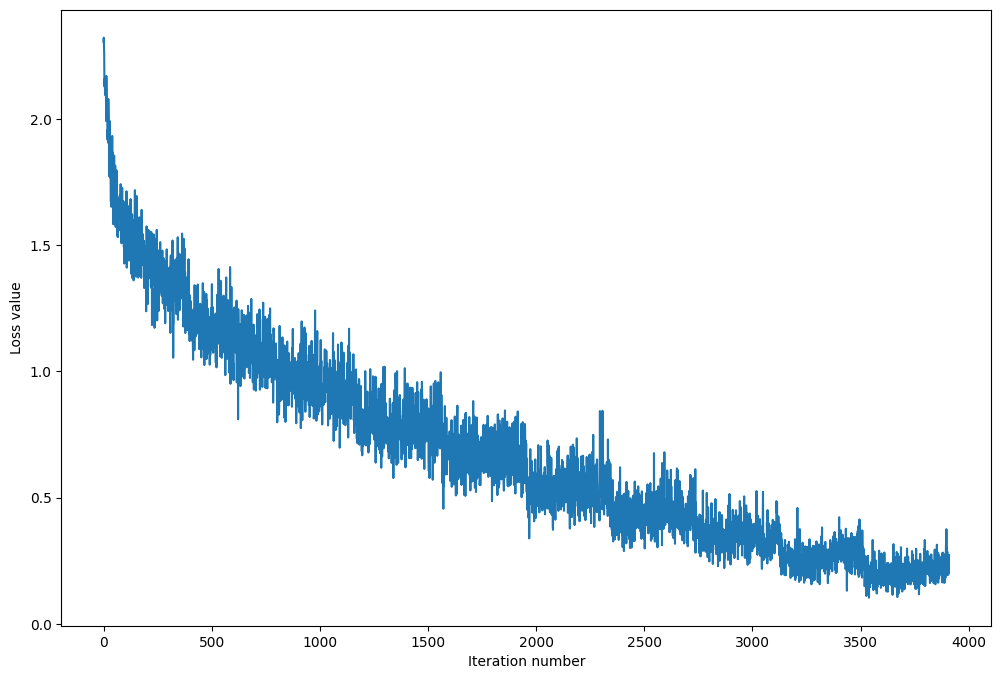

In [22]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 2.5.5 Quantitative Analysis

Analyze your model quantitatively.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [24]:
correct = 0
total = 0
model = model.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 69 %
